# Imports libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## Load data 

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

#keep the passengerId in a variable for the end
passenger_ids = df_test['PassengerId'].copy()

## Concatenate data in one file

In [3]:
# df = pd.concat([df_train, df_test], ignore_index=True)
# df.to_csv('data/concat_data.csv', index=False)

# df_concat = pd.read_csv('data/concat_data.csv')

## Total spending money in RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

### Add missing values in CryoSleep, Destination and in spending columns

In [4]:
exp_features = ["RoomService", 
                "FoodCourt", 
                "ShoppingMall", 
                "Spa",
                "VRDeck"
]

def split_passenger_id(df: pd.DataFrame):
  df['Group'] = df['PassengerId'].apply(lambda x: int(x.split('_')[0]))
  df['Group_size'] = df['Group'].map(lambda x: pd.concat([df['Group']]).value_counts()[x])

  df['Solo'] = (df['Group_size'] == 1).astype(int)

  df = df.drop(['PassengerId'], axis=1)
  return df

def split_cabin(df: pd.DataFrame):
  df['Cabin'] = df['Cabin'].fillna('Z/9999/Z', inplace=True)

  df['Cabin_Deck'] = df['Cabin'].apply(lambda x: str(x).split('/')[0])
  df['Cabin_Side'] = df['Cabin'].apply(lambda x: str(x).split('/')[-1])

  df = df.drop(['Cabin'], axis=1)

  # grouped_df_deck = df[df['Group_size']>1].groupby(['Group','Cabin_Deck'])['Cabin_Deck'].size().unstack().fillna(0)
  # grouped_df_side = df[df['Group_size']>1].groupby(['Group','Cabin_Side'])['Cabin_Side'].size().unstack().fillna(0)

  # CS_bef=df['Cabin_Side'].isna().sum()

  # GCS_index=df[df['Cabin_Side'].isna()][(df[df['Cabin_Side'].isna()]['Group']).isin(grouped_df_side.index)].index
  # df.loc[GCS_index,'Cabin_Side']=df.iloc[GCS_index,:]['Group'].map(lambda x: grouped_df_side.idxmax(axis=1)[x])

  # print('#Cabin_side missing values before:',CS_bef)
  # print('#Cabin_side missing values after:',df['Cabin_Side'].isna().sum())
  return df

def split_name(df: pd.DataFrame):
  df['Name'] = df['Name'].fillna('Unknown Unknown')

  df['Surname'] = df['Name'].str.split().str[-1]
  df['Family_size'] = df['Surname'].map(lambda x: df['Surname'].value_counts()[x])

  df.loc[df['Surname']=='Unknown','Surname']=np.nan
  df.loc[df['Family_size']>100,'Family_size']=np.nan

  df = df.drop(['Name'], axis=1)
  return df

def add_total_spending(data: pd.DataFrame):
  data["TotalSpending"] = data[exp_features].sum(axis=1)
  return data

def add_missing_cryo(df: pd.DataFrame):
  df.loc[(df['CryoSleep'].isna()) & (df['TotalSpending'] > 0), 'CryoSleep'] = False
  df.loc[(df['CryoSleep'].isna()) & (df['TotalSpending'] == 0), 'CryoSleep'] = True
  return df

def add_missing_spending(df: pd.DataFrame):
  for feature in exp_features:
    df.loc[(df[feature].isna()) & (df['CryoSleep'] == True), feature] = 0
    df.loc[(df[feature].isna()) & (df['CryoSleep'] == False), feature] = df[feature].median()
  return df

def add_missing_destination(df: pd.DataFrame):
  df.loc[(df['Destination'].isna()), 'Destination']='TRAPPIST-1e'
  return df

def add_missing_homeplanet(df: pd.DataFrame):
  df_grouped = df.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
  df_index = df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['Group']).isin(df_grouped.index)].index
  df.loc[df_index, 'HomePlanet'] = df.iloc[df_index,:]['Group'].map(lambda x: df_grouped.idxmax(axis=1)[x])

  grouped_df = df.groupby(['Cabin_Deck', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
  df.loc[(df['HomePlanet'].isna()) & (df['Cabin_Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'
  df.loc[(df['HomePlanet'].isna()) & (df['Cabin_Deck'].isin(['G'])), 'HomePlanet'] = 'Earth'

  grouped_df = df.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
  df_index = df[df['HomePlanet'].isna()][(df[df['HomePlanet'].isna()]['Surname']).isin(grouped_df.index)].index
  df.loc[df_index, 'HomePlanet'] = df.iloc[df_index,:]['Surname'].map(lambda x: grouped_df.idxmax(axis=1)[x])

  grouped_df = df.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)
  df.loc[(df['HomePlanet'].isna()) & ~(df['Cabin_Deck']=='D'), 'HomePlanet']='Earth'
  df.loc[(df['HomePlanet'].isna()) & (df['Cabin_Deck']=='D'), 'HomePlanet']='Mars'
  return df

def add_group_size(df: pd.DataFrame):
  
  df_grouped = df[df['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack(fill_value=0)

  df_index = df[df['Surname'].isna()][(df[df['Surname'].isna()]['Group']).isin(df_grouped.index)].index
  df.loc[df_index,'Surname']=df.iloc[df_index,:]['Group'].map(lambda x: df_grouped.idxmax(axis=1)[x])

  if not df_grouped.empty:
    # mapping Group -> most frequent surname (could be NaN)
    most_freq = df_grouped.idxmax(axis=1).to_dict()
    mask = df['Surname'].isna() & df['Group'].isin(df_grouped.index)
    df.loc[mask, 'Surname'] = df.loc[mask, 'Group'].map(most_freq)

  df['Surname'] = df['Surname'].fillna('Unknown')
  df['Family_size']=df['Surname'].map(lambda x: df['Surname'].value_counts()[x])
  df.loc[df['Surname']=='Unknown','Surname']=np.nan
  df.loc[df['Family_size']>100,'Family_size']=0
  return df

## Clean data

In [5]:
def clean(data: pd.DataFrame):
  data = split_passenger_id(data)
  data = split_cabin(data)
  data = split_name(data)

  data = add_group_size(data)
  data = add_total_spending(data)
  data = add_missing_cryo(data)
  data = add_missing_spending(data)
  data = add_missing_destination(data)
  data = add_missing_homeplanet(data)
  data = data.drop(["VIP", "Surname"], axis=1)
  return data

df_train_cleaned = clean(df_train)
print(df_train_cleaned.isna().sum())
df_test_cleaned = clean(df_test)

/var/folders/1y/2x2sk6rx47s_4dr81fgvxj2c0000gn/T/ipykernel_8363/2578995500.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'] = df['Cabin'].fillna('Z/9999/Z', inplace=True)


HomePlanet         0
CryoSleep          0
Destination        0
Age              179
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported        0
Group              0
Group_size         0
Solo               0
Cabin_Deck         0
Cabin_Side         0
Family_size        0
TotalSpending      0
dtype: int64


/var/folders/1y/2x2sk6rx47s_4dr81fgvxj2c0000gn/T/ipykernel_8363/2578995500.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cabin'] = df['Cabin'].fillna('Z/9999/Z', inplace=True)


## Display NAN values


In [6]:
print('Train set missing values:')
print(df_train.isna().sum())
print("")
print('Test set missing values:')
print(df_test.isna().sum())

Train set missing values:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
Group_size        0
Solo              0
dtype: int64

Test set missing values:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
Group_size        0
Solo              0
dtype: int64


## Correlation with PassengerId

In [7]:
# df = df_train[['Transported', 'PassengerId']].astype({'Transported': 'bool', 'PassengerId': str})

# transported = df['Transported'].to_numpy()
# passenger_prefix = df['PassengerId'].fillna('').astype(str).str.split('_', n=1).str[0].replace('', pd.NA)

# passenger_prefix_dummies = pd.get_dummies(passenger_prefix)

# pearson_corr = np.corrcoef(transported, passenger_prefix_dummies.T)[0, 1]
# print(pearson_corr)

# passenger_levels = np.sort(df['PassengerId'].unique())
# transported_rates = [df.loc[df['PassengerId'] == level, 'Transported'].mean() for level in passenger_levels]
# counts = [df.loc[df['PassengerId'] == level].sum() for level in passenger_levels]

# fig, axes = plt.subplots(figsize=(10, 8))

# axes.bar(passenger_levels, transported_rates)
# axes.set_xlabel('PassengerId')
# axes.set_ylabel('Transported Rate')
# axes.set_title('Transported Rate by PassengerId')
# plt.show()

## Correlation with CryoSleep

In [8]:
# df = df_train_cleaned[['Transported', 'CryoSleep']].dropna().astype('bool')

# transported = df['Transported'].to_numpy()
# cryo_sleep = df['CryoSleep'].to_numpy()

# pearson_corr = np.corrcoef(transported, cryo_sleep)[0, 1]
# print(pearson_corr)

# cryo_sleep_levels = np.sort(df['CryoSleep'].unique())
# transported_rates = [df.loc[df['CryoSleep'] == level, 'Transported'].mean() for level in cryo_sleep_levels]
# counts = [df.loc[df['CryoSleep'] == level].shape[0] for level in cryo_sleep_levels]

# fig, axes = plt.subplots(figsize=(6, 6))

# axes.bar(cryo_sleep_levels.astype(str), transported_rates)
# axes.set_xlabel('CryoSleep')
# axes.set_ylabel('Transported Rate')
# # axes.set_title('Transported Rate by CryoSleep')
# for i, v in enumerate(transported_rates):
#   axes.text(i, v + 0.02, f'{v:.4f}\n(n={counts[i]})', ha='center')

# plt.show()

## Correlation with VIP

-0.0376497222591981


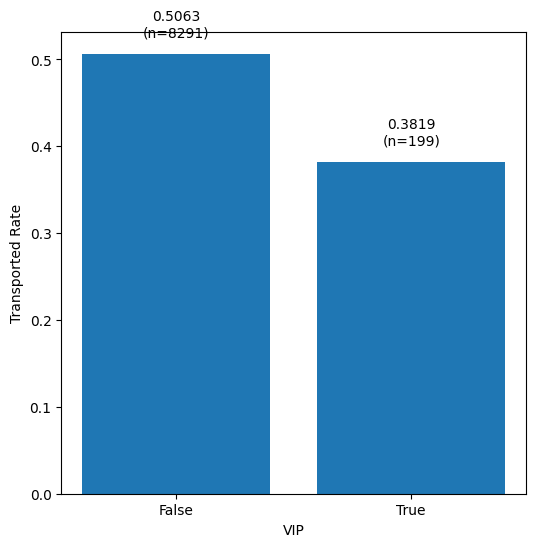

In [9]:
df = df_train[['Transported', 'VIP']].dropna().astype({'Transported': 'bool', 'VIP': 'bool'})

transported = df['Transported'].to_numpy()
vip = df['VIP'].to_numpy()

pearson_corr = np.corrcoef(transported, vip)[0, 1]
print(pearson_corr)

vip_levels = np.sort(df['VIP'].unique())
transported_rates = [df.loc[df['VIP'] == level, 'Transported'].mean() for level in vip_levels]
counts = [df.loc[df['VIP'] == level].shape[0] for level in vip_levels]

fig, axes = plt.subplots(figsize=(6, 6))

axes.bar(vip_levels.astype(str), transported_rates)
axes.set_xlabel('VIP')
axes.set_ylabel('Transported Rate')
# axes.set_title('Transported Rate by CryoSleep')
for i, v in enumerate(transported_rates):
  axes.text(i, v + 0.02, f'{v:.4f}\n(n={counts[i]})', ha='center')

plt.show()

## Correlation with Spending columns

In [10]:
df_train[["Transported", "RoomService", "FoodCourt", "ShoppingMall", "Spa","VRDeck"]]

,Transported,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,False,0.0,0.0,0.0,0.0,0.0
1,True,109.0,9.0,25.0,549.0,44.0
2,False,43.0,3576.0,0.0,6715.0,49.0
3,False,0.0,1283.0,371.0,3329.0,193.0
4,True,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...,...
8688,False,0.0,6819.0,0.0,1643.0,74.0
8689,False,0.0,0.0,0.0,0.0,0.0
8690,True,0.0,0.0,1872.0,1.0,0.0
8691,False,0.0,1049.0,0.0,353.0,3235.0


## Training model

In [11]:
y = df_train_cleaned['Transported'].astype('bool')
features = ["CryoSleep", 
            "RoomService", 
            "FoodCourt", 
            "ShoppingMall", 
            "Spa", 
            "VRDeck",
            "TotalSpending",
            "HomePlanet",
            "Destination",
            "Age",
            "Cabin_Deck",
            "RoomService",
            "FoodCourt",
            "ShoppingMall",
            "Spa",
            "VRDeck",
            "Family_size",
            "Solo",
            "Cabin_Side",
            "Cabin_Deck",
]

X = pd.get_dummies(df_train_cleaned[features])
X_test = pd.get_dummies(df_test_cleaned[features])

model = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': predictions})
output.to_csv('submission.csv', index=False)

## Test with Copilot

In [ ]:
from sklearn.model_selection import cross_val_score

# Kaggle Score Simulation
print("\n" + "="*50)
print("KAGGLE SCORE SIMULATION")
print("="*50)

# Separate features and target
y = df_train['Transported']
X = df_train.drop('Transported', axis=1)

# Clean the data
X_cleaned = clean(X.copy())

# Handle remaining missing values and encode categorical variables
X_cleaned = X_cleaned.fillna(X_cleaned.median(numeric_only=True))
X_cleaned = pd.get_dummies(X_cleaned, drop_first=True)

# Cross-validation
model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(model, X_cleaned, y, cv=5, scoring='accuracy')

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\n📊 Expected Kaggle Score Range: {cv_scores.mean() - cv_scores.std():.4f} - {cv_scores.mean() + cv_scores.std():.4f}")